Fai un programa en Python que coa imaxe escaneada:

- Identifica os cuadrilateros da imaxe.

- Conta o número de "circulos" e encerraos dentro dun cuadrilatero

## 1. Importación de librerías y carga de imagen

Text(0.5, 1.0, 'Imagen escaneada en escala de grises')

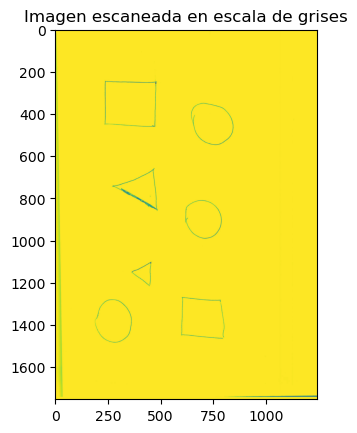

In [26]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img_original = cv.imread("Escaneo-cargador.jpg",0) # el 0 hace que se cargue directamente en escala de grises
plt.imshow(img_original)
plt.title('Imagen escaneada en escala de grises')



## 2. Recorte de imagen

(([], []), ([], []))

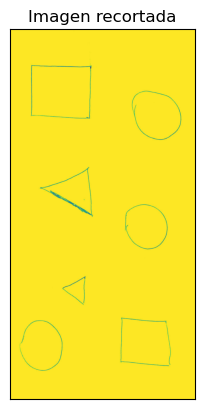

In [27]:
recorte = img_original[100:1600,150:900]
plt.imshow(recorte)
plt.title('Imagen recortada') 
plt.xticks([]), plt.yticks([]) # oculta ejes para visión más limpia

## 3. Detección de bordes con Canny

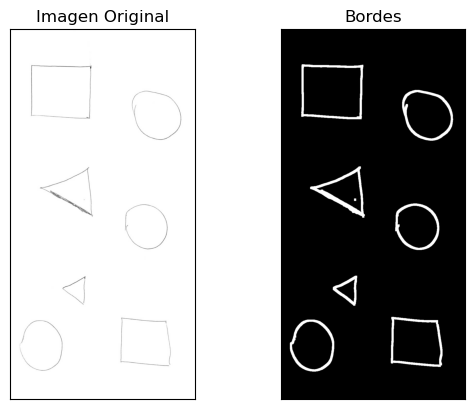

In [28]:
bordes = cv.Canny(recorte, 100, 200) # 100 y 200 son umbrales que definen qué es considerado borde y qué no. Por debajo de 100 se descartan como borde, por encima de 200 es borde seguro. Entre 100 y 200 sería un borde débil.

kernel = np.ones((7,7), np.uint8)

bordes = cv.dilate(bordes, kernel, iterations=1)


plt.subplot(121), plt.imshow(recorte, cmap='gray')
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(bordes, cmap='gray')
plt.title('Bordes'), plt.xticks([]), plt.yticks([])
plt.show()

## 4. Detección de contornos (figuras)

In [32]:
cnts, hierarchy = cv.findContours(bordes, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) # cv.RETR_EXTERNAL detecta los contornos externos, es decir, las figuras de la imagen (ignora si hay algo dentro de ellos, para eso habría que usar cv.RETR_TREE)
                                                                                    # cv.CHAIN_APPROX_SIMPLE se queda con los puntos esenciales para detectar los contornos (evita gasto en memoria. cv.CHAIN_APPROX_NONE guardaría todos los puntos del contorno)
print(f"Número de contornos: {len(cnts)}")

Número de contornos: 7


## 5. Dibujar contorno sobre las figuras

Se han detectado 2 cuadriláteros.
Total figuras: {'Círculo': 3, 'Cuadrilátero': 2, 'Otro': 1, 'Triángulo': 1}


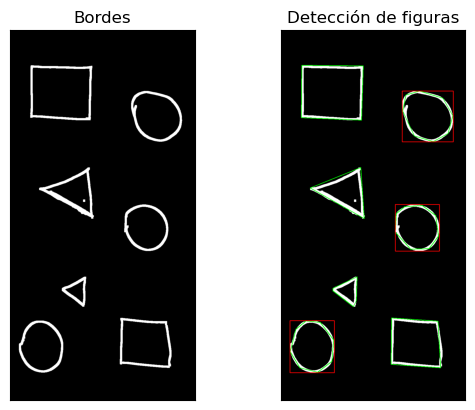

In [48]:
# Se convierte la imagen a RGB para poder dibujar sobre ella
conContornos = cv.cvtColor(bordes, cv.COLOR_GRAY2RGB)

shapes = {} # diccionario para guardar las distintas figuras

for cnt in cnts:
    # Calcular la aproximación del contorno, con el perímetro como punto de referencia
    epsilon = 0.02 * cv.arcLength(cnt, True) ## 2% del perímetro. Cuanto más pequeño sea este valor, más aproximado será el contorno
    approx = cv.approxPolyDP(cnt, epsilon, True)

    # Dibuja el contorno en color verde (0, 255, 0) y con grosor 2
    cv.drawContours(conContornos, [approx], -1, (0, 255, 0), 2)

    # Clasificar las figuras. Si tiene 3 vértices = triángulo, 4 = cuadrilátero
    if len(approx) == 3:
        shape = "Triángulo"
    elif len(approx) == 4:
        shape = "Cuadrilátero"
    else:
        M = cv.moments(cnt)
        area = cv.contourArea(cnt)
        perimeter = cv.arcLength(cnt,True)
        approx = cv.approxPolyDP(cnt,0.01*perimeter,True)
         # Fórmula para detectar si es un círculo. Si el resultado > 0.8 se considera círculo, sino "otro"
        circularity = 4*np.pi*(area/(perimeter*perimeter))
        if circularity > 0.8:
            shape = "Círculo"
            # Dibuja rectángulo alrededor del círculo
            x, y, w, h = cv.boundingRect(cnt)
            cv.rectangle(conContornos, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Azul
        else:
            shape = "Otro"
                
    shapes[shape] = shapes.get(shape, 0) + 1

# Printeamos los cuadrados encontrados
print(f'Se han detectado {shapes["Cuadrilátero"]} cuadriláteros.')
print(f'Total figuras: {shapes}')

#Mostrar los resultados
plt.subplot(121), plt.imshow(bordes, cmap='gray')
plt.title('Bordes'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(conContornos)
plt.title('Detección de figuras'), plt.xticks([]), plt.yticks([])
plt.show()
